# Statistical Analysis

This script performs a statistical analysis - more specifically the F-test / ANOVA - on the data obtained during simulations throughout the thesis. An F-test can compare the means of various groups and determine if they are equal by looking at their variances. This is done by **checking the variations between the groups compared to the variations within each group**.

In this script, I'll try to prove that each of the given group's results (mean) is significantly different from those of the other populations.

The null hypothesis is that all populations are equal to each other, which we try to reject. A rejection of the null hypothesis implies that at least one distinct population can be made. In other words, if one can reject the null hypothesis, this would mean that there are at least two group means that are statistically significantly different from each other.

If the null hypothesis is correct, than all means of the groups are equal. This would result in a low F-score (close to one).

Based on: 
* https://medium.com/@rrfd/f-tests-and-anovas-examples-with-the-iris-dataset-fe7caa3e21d0
* https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as smm
from utils.myutils import load_dict
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.interpolate import make_interp_spline

## Hyperparameters

In [2]:
experiment = 1
use_backup = True
populations = ['NEAT', 'NEAT-GRU', 'NEAT-LSTM', 'NEAT-SRU', 'NEAT-SRU-S']  # NEAT, NEAT-GRU, NEAT-LSTM, NEAT-SRU, NEAT-SRU-S
field = 'finished'  # finished, fitness, or score
generation = 500

## Load in the data

It is assumed that the evaluation of the populations has already finished.

In [3]:
data = []
path = f"population{'_backup' if use_backup else ''}/storage/experiment{experiment}/"
for pop in populations:
    d = load_dict(f"{path}{pop}/evaluation/{field}")
    data.append(d[str(generation)])
df = pd.DataFrame(np.asarray(data).transpose(), columns=populations)
df.head()

,NEAT,NEAT-GRU,NEAT-LSTM,NEAT-SRU,NEAT-SRU-S
0,0.25,1.0,1.0,0.90,0.70
1,0.30,1.0,1.0,0.60,0.15
2,0.75,1.0,1.0,0.95,0.95
3,0.15,1.0,1.0,0.40,0.65
4,0.15,1.0,1.0,1.00,0.50


In [4]:
df.mean()

NEAT          0.214
NEAT-GRU      0.996
NEAT-LSTM     0.997
NEAT-SRU      0.850
NEAT-SRU-S    0.570
dtype: float64

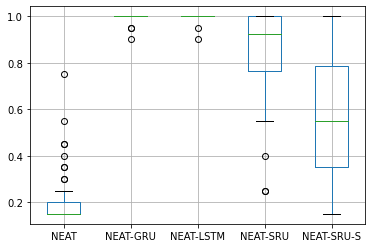

In [5]:
df.boxplot()

## Handle outliers

In [6]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR

NEAT          0.0500
NEAT-GRU      0.0000
NEAT-LSTM     0.0000
NEAT-SRU      0.2375
NEAT-SRU-S    0.4375
dtype: float64

In [7]:
# No normalisation
# df_n = df

# Normaized dataframes (without any outliers)
df_n = df[(df >= (Q1 - 1.5 * IQR)) & (df <= (Q3 + 1.5 * IQR))]

# Quantile dataframes (only values in the quantiles are kept)
# df_n = df[(df >= Q1) & (df <= Q3)]

df_n.head()

,NEAT,NEAT-GRU,NEAT-LSTM,NEAT-SRU,NEAT-SRU-S
0,0.25,1.0,1.0,0.90,0.70
1,NaN,1.0,1.0,0.60,0.15
2,NaN,1.0,1.0,0.95,0.95
3,0.15,1.0,1.0,NaN,0.65
4,0.15,1.0,1.0,1.00,0.50


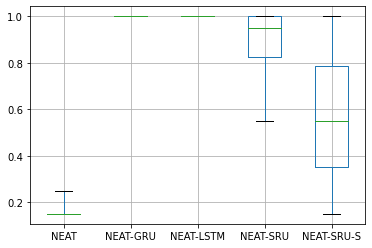

In [8]:
df_n.boxplot(whis=[0,100])  # Do not define outliers anymore

## Probability distribution

Show how the probabilities for the given metric compare between populations.

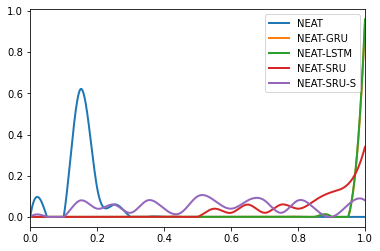

In [9]:
# Put the data into bins
bins = 20
df_r = (df_n*bins).round()/bins

# Show the probabilities of each population
x = [i/bins for i in range(bins+1)]
plt.figure()
for pop in populations:
    y = [len(df_r[pop][df_r[pop] == i])/len(df) for i in x]
    #plt.bar(x,y,width=0.05)
    #plt.plot(x,y, label=pop)
    
    y_new = np.linspace(0,1,1000)
    a_BSpline = make_interp_spline(x,y)
    x_new = a_BSpline(y_new)
    x_new = np.clip(x_new, a_min=0, a_max=1)
    plt.plot(y_new, x_new, linewidth=2, label=pop)
    
plt.legend()
plt.xlim(0,1)
plt.show()
plt.close()

## Test for normality

This part will test if the data we work with is normally distributed. If the distribution is not normal, an F-test should not be used.

In [10]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro
for pop in populations:
    stat, p = shapiro(df_n[pop].dropna())
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'{pop} is probably Gaussian (p={p:.5f})')
    else:
        print(f'{pop} is probably not Gaussian (p={p:.5f})')

stat=0.567, p=0.000
NEAT is probably not Gaussian (p=0.00000)
stat=1.000, p=1.000
NEAT-GRU is probably Gaussian (p=1.00000)
stat=1.000, p=1.000
NEAT-LSTM is probably Gaussian (p=1.00000)
stat=0.813, p=0.000
NEAT-SRU is probably not Gaussian (p=0.00000)
stat=0.954, p=0.049
NEAT-SRU-S is probably not Gaussian (p=0.04939)


c:\users\ruben\documents\projects\evolvablernn\venv\lib\site-packages\scipy\stats\morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


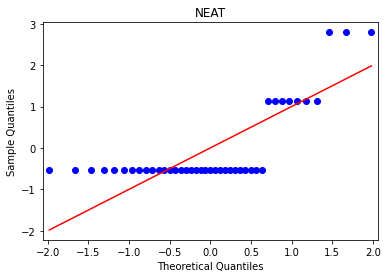

c:\users\ruben\documents\projects\evolvablernn\venv\lib\site-packages\statsmodels\graphics\gofplots.py:237: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


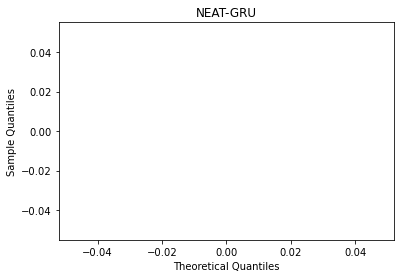

c:\users\ruben\documents\projects\evolvablernn\venv\lib\site-packages\statsmodels\graphics\gofplots.py:237: RuntimeWarning: invalid value encountered in true_divide
  return (self.sorted_data-self.loc)/self.scale


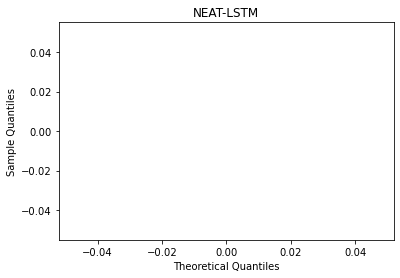

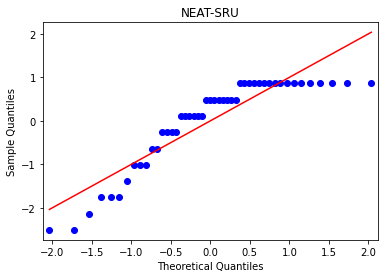

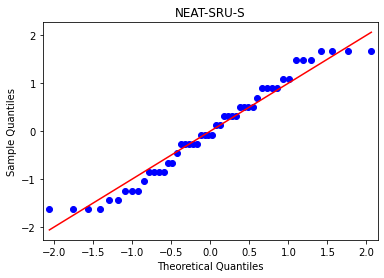

In [11]:
sm.qqplot(df_n['NEAT'].dropna(), line ='s', fit=True) 
plt.title('NEAT')
plt.show() 
sm.qqplot(df_n['NEAT-GRU'].dropna(), line ='s', fit=True) 
plt.title('NEAT-GRU')
plt.show() 
sm.qqplot(df_n['NEAT-LSTM'].dropna(), line ='s', fit=True) 
plt.title('NEAT-LSTM')
plt.show() 
sm.qqplot(df_n['NEAT-SRU'].dropna(), line ='s', fit=True) 
plt.title('NEAT-SRU')
plt.show() 
sm.qqplot(df_n['NEAT-SRU-S'].dropna(), line ='s', fit=True) 
plt.title('NEAT-SRU-S')
plt.show() 

## Statistical Hypothesis

Do further research on the interpretation:
* https://www.socscistatistics.com/tests/mannwhitney/
* https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
* https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance

In [12]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df_n['NEAT-LSTM'].dropna(), df_n['NEAT-GRU'].dropna())
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

ValueError: All numbers are identical in mannwhitneyu

In [ ]:
from scipy.stats import kruskal
stat, p = kruskal(df_n['NEAT-LSTM'].dropna(), df_n['NEAT-GRU'].dropna())
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

## T-test

May only be done if normally distributed!

In [ ]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(df_n['NEAT-LSTM'].dropna(), df_n['NEAT-GRU'].dropna())
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')